In [1]:
%load_ext autoreload
%autoreload 2

# %load_ext memory_profiler

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 

import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)



# from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm

from mlelec.utils.twocenter_utils import _to_coupled_basis
# from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase

from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH, twocenter_hermitian_features

# from mlelec.utils.pbc_utils import kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
# from mlelec.utils.plot_utils import plot_block_errors

import metatensor as mts
from metatensor import Labels, TensorBlock, TensorMap


# from mlelec.utils.target_utils import get_targets




# import metatensor.torch as mts
# from metatensor.torch import Labels, TensorBlock, TensorMap
# import rascaline.torch
# from mlelec.data.dataset import QMDataset

In [3]:
device = 'cpu'

In [4]:
orbitals = {
    
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },
    'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},

     'saph':{
               8: [[2, 0, 0], [2, 1, 1], [2, 1, -1], [2, 1, 0]], 
               6: [[2, 0, 0], [2, 1, 1], [2, 1, -1], [2, 1, 0]], 
               1: [[1, 0, 0]]
               }
                                                                 
                                                                 
                                                                 
}

In [5]:
# import rascaline

# from mlelec.features.acdc import compute_features

In [6]:
from mlelec.models.linear import LinearModelPeriodic, LinearTargetModel
device='cpu'

In [7]:
def check_target(coupled_blocks, tol=1e-4):
    """ Checks that the coupled blocks, when n1, l1 = n2, l2, satisfy 
            - block_type=1, lambda = ODD blocks are zero, 
            - block_type=-1, lambda = EVEN blocks are zero 
    """
    for k, b in coupled_blocks.items():
        btype= k['block_type']
        L = k['L']
        l1 = k['l_i']
        l2 = k['l_j']
        n1 = k['n_i']
        n2 = k['n_j']
        if L%2==0 and btype==-1 and (n1==n2) and (l1==l2):
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')#, values,{b.values[failidx]}' )

        elif L%2==1 and btype==1 and (n1==n2) and (l1==l2):
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')#, values,{b.values[failidx]}' )
  
                # print(f'try minus bytpe, {torch.norm(newb.values[failidx])}')

    print('TARGET PASSED')
def check_gij(gij, tol = 1e-4):
    """ Similar to the checks on the target above, we can check for gij that 
        - block_type = 1 < n| gij; lambda = ODD> = 0
        - block_type = -1 <n | gij; lambda = EVEN> = 0
    (inversion sigma = 1 for all of these blocks since they are directly the SPH components)
    """ 
    for k, b in gij.items(): 
        btype= k['block_type']
        L = k['spherical_harmonics_l']
        if L%2==0 and btype==-1 : 
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')
        elif L%2==1 and btype==1:
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')

    print('gij PASSED')

In [8]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

# WATER 

In [10]:
import hickle
N  = 500
workdir = '../my_mlelec/examples/data/water_1000'
frames = read(f'{workdir}/water_1000.xyz',slice(0,N))
fock = hickle.load(f'{workdir}/sto-3g/fock.hickle')[:N]
overlap = hickle.load(f'{workdir}/sto-3g/overlap.hickle')[:N]

In [11]:
max_radial  = 12
max_angular = 8
atomic_gaussian_width = 0.3
LCUT = 4

hypers_atom = {'cutoff': 3,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
all_pairs = False


cutoff = 4
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis":  {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

# hfeat = compute_features(dataset, hypers_atom=hypers_atom, hypers_pair=hypers_pair, lcut=LCUT)

In [12]:
from mlelec.data.dataset import MoleculeDataset, MLDataset
mol_data = MoleculeDataset(
    mol_name="water",
    use_precomputed=False,
    frames = frames,  # Uses precomputed data by this name 
    frame_slice=slice(0, N), # Loads 100 frames 
    device="cpu",
    target_data = {"fock": fock},
    aux_data={"overlap": overlap, "orbitals": orbitals['sto-3g']},
    aux=["overlap", "orbitals"],
    target=["fock"],
)

In [13]:
ml_data = MLDataset(
    molecule_data=mol_data,
    device="cpu",
    model_strategy="coupled", # We will be building models for coupled blocks 
    shuffle=False,
    # shuffle_seed=None,
)  

ml_data._split_indices(0.8,0,0.2)

In [14]:
from mlelec.features.acdc import compute_features_for_target
hfeat = compute_features_for_target(ml_data, hypers=hypers_atom, hypers_pair=hypers_pair, lcut=LCUT, device = 'cpu')

here, single center features


/home/nigam/miniconda3/envs/mlelec_molecule/lib/python3.12/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


here, single center features


In [ ]:
for k in ["cell_shift_a", "cell_shift_b", "cell_shift_c","cell_shift_a_MIC","cell_shift_b_MIC", "cell_shift_c_MIC"]:
    hfeat = mts.remove_dimension(hfeat, "keys", k)

In [ ]:
NTRAIN = len(ml_data.train_idx)#00
trainidx = np.arange(0, NTRAIN)
testidx = np.arange(NTRAIN, N)#len(dataset))

In [ ]:
hfeat_train = mts.slice(hfeat, 'samples', Labels(['structure'], values = (trainidx).reshape(-1,1)))
hfeat_test = mts.slice(hfeat, 'samples', Labels(['structure'], values = (testidx).reshape(-1,1)))

In [ ]:
# hfeat.save(f'{savedir}/hfeat_500')
# target_coupled_blocks.save(f'{savedir}/coupledblocks_500')

In [ ]:
target_coupled_blocks = ml_data.target.blocks_coupled

In [ ]:
ml_data._set_features(hfeat_train)

In [ ]:
target_train = mts.slice(target_coupled_blocks, 'samples', Labels(['structure'], values = (trainidx).reshape(-1,1)))
target_test = mts.slice(target_coupled_blocks, 'samples', Labels(['structure'], values = (testidx).reshape(-1,1)))

In [ ]:
# model_ridge = LinearModelPeriodic(twocfeat = hfeat_train, 
#                                   target_blocks = target_train,
#                                 #   frames = dataset.structures, 
#                                  frames = frames, 
#                                 #   orbitals = dataset.orbitals, 
#                                   orbitals = mol_data.aux_data["orbitals"], 
#                                   device = device)
model_ridge = LinearTargetModel(
    dataset=ml_data, nlayers=1, nhidden=16, bias=False, device="cpu"
)

model_ridge = model_ridge.double()
# loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
#                                                                          target_train,
#                                                                          set_bias = True,
#                                                                          kernel_ridge = False,
#                                                                          alphas = np.logspace(-8, -7, 100),
#                                                                          # alphas = np.logspace(-30, -6, 100),
#                                                                          # alpha = 1e-4
#                                                                         )
pred_train, ridges = model_ridge.fit_ridge_analytical(set_bias=True,alphas = np.logspace(-8, -5, 100),)
# print(loss_ridge_bias)


In [ ]:
from mlelec.metrics import L2_loss  
L2_loss(pred_train, target_train).item()

3.4387481748169665e-07

In [ ]:
pred_test = model_ridge.predict_ridge_analytical(hfeat = hfeat_test, target_blocks = target_test)

In [ ]:
# pred_test = pred_test.to("cpu")
L2_loss(pred_test, target_test).item()

0.00010769928531769318

In [ ]:
from mlelec.utils.twocenter_utils import (
    map_targetkeys_to_featkeys,
    _to_uncoupled_basis,
    _to_matrix,
)
            
recon_H_train  = _to_matrix(
    _to_uncoupled_basis(pred_train, device="cpu" ),
   ml_data.train_frames,
    ml_data.target.orbitals,
    device="cpu",
)

In [ ]:
recon_H_test  = _to_matrix(
    _to_uncoupled_basis(pred_test, device="cpu" ),
   ml_data.test_frames,
    ml_data.target.orbitals,
    device="cpu",
)

In [ ]:
# recon_H_train = recon_H_train.reshape(1, *recon_H_train.shape)
# recon_H_test = recon_H_test.reshape(1, *recon_H_test.shape)

In [ ]:
ml_data.target.tensor[trainidx].shape

torch.Size([800, 7, 7])

In [ ]:
L2_loss(recon_H_train, ml_data.target.tensor[trainidx]).item()

0.0009163376814267051

In [ ]:
L2_loss(recon_H_test, ml_data.target.tensor[testidx]).item()

0.00031184776579799877

In [ ]:
# torch.sqrt(torch.sum((recon_H- ml_data.target.tensor[0])**2)/(72*72)) *27.211

In [ ]:
pred_focks = torch.vstack([recon_H_train, recon_H_test])
from mlelec.utils.twocenter_utils import fix_orbital_order
fixed_overlaps = fix_orbital_order(
            overlap, frames=frames, orbital=mol_data.aux_data["orbitals"]
        )

In [ ]:
import scipy
eigs = [scipy.linalg.eigvalsh(pred_focks[i], fixed_overlaps[i]) for i in range(N)]
eigs_actual = [scipy.linalg.eigvalsh(ml_data.target.tensor[i], fixed_overlaps[i]) for i in range(N)]

# eigs = [scipy.linalg.eigvals(pred_focks[i]) for i in range(len(dataset))]
# eigs_actual = [scipy.linalg.eigvals(fock[i]) for i in range(len(dataset))]

In [ ]:
eigs_train_occ = [scipy.linalg.eigvalsh(recon_H_train[i], fixed_overlaps[i])[1:5] for i in range(NTRAIN)]
eigs_actual_train_occ= [scipy.linalg.eigvalsh(ml_data.target.tensor[i], fixed_overlaps[i])[1:5] for i in range(NTRAIN)]

eigs_train_unocc = [scipy.linalg.eigvalsh(recon_H_train[i], fixed_overlaps[i])[5:] for i in range(NTRAIN)]
eigs_actual_train_unocc= [scipy.linalg.eigvalsh(ml_data.target.tensor[i], fixed_overlaps[i])[5:] for i in range(NTRAIN)]

In [ ]:
eigs_test_occ = [scipy.linalg.eigvalsh(recon_H_test[i], fixed_overlaps[i+NTRAIN])[1:4] for i in range(N-NTRAIN)]
eigs_actual_test_occ = [scipy.linalg.eigvalsh(ml_data.target.tensor[i+NTRAIN], fixed_overlaps[i+NTRAIN])[1:4] for i in range(N-NTRAIN)]

eigs_test_unocc = [scipy.linalg.eigvalsh(recon_H_test[i], fixed_overlaps[i+NTRAIN])[4:] for i in range(N-NTRAIN)]
eigs_actual_test_unocc = [scipy.linalg.eigvalsh(ml_data.target.tensor[i+NTRAIN], fixed_overlaps[i+NTRAIN])[4:] for i in range(N-NTRAIN)]

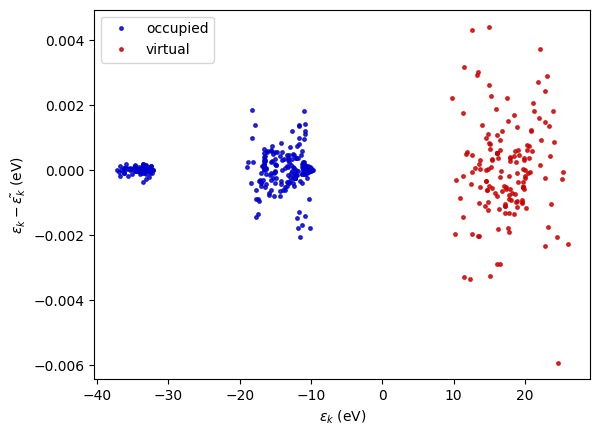

In [ ]:
from ase.units import Hartree
ha2ev = Hartree
alleva = np.concatenate(eigs_actual_train_occ)
allpred = np.concatenate(eigs_train_occ)

alleva_unocc = np.concatenate(eigs_actual_train_unocc)
allpred_unocc = np.concatenate(eigs_train_unocc)
                         
plt.plot(allpred*ha2ev, (alleva-allpred)*ha2ev, color=(0,0,0.8,0.8), linestyle="", 
         marker=".", markersize=5)

plt.plot(allpred[0]*ha2ev, (alleva-allpred)[0]*ha2ev, color=(0,0,0.8,0.8), linestyle="", 
         marker=".", markersize=5, label = 'occupied')

plt.plot(allpred_unocc*ha2ev, (alleva_unocc-allpred_unocc)*ha2ev, color=(0.8,0,0,0.8), linestyle="", 
         marker=".", markersize=5)

plt.plot(allpred_unocc[0]*ha2ev, (alleva_unocc-allpred_unocc)[0]*ha2ev, color=(0.8,0,0,0.8), linestyle="", 
         marker=".", markersize=5, label = 'virtual')

# plt.xlim(-4,4)
plt.ylabel(r'$\epsilon_k - \tilde{\epsilon_k}$ (eV)')
plt.xlabel(r'$\epsilon_k$ (eV)')
plt.legend(loc='upper left')
# alleva = np.concatenate(eigs_actual_train_occ)
# allpred = np.concatenate(eigs_train_occ)
plt.savefig('water_1000_test_unoccupied.pdf', dpi=300, bbox_inches='tight')


# plt.savefig('water_1000_test_occupied.pdf', dpi=300, bbox_inches='tight')

In [82]:
! pwd

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec


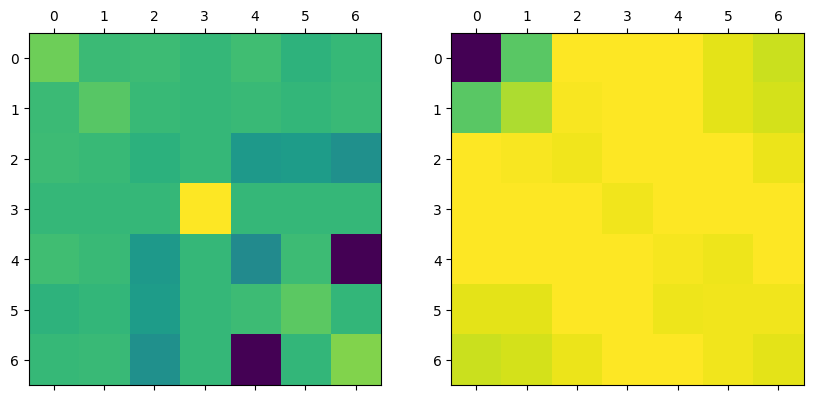

In [42]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].matshow(recon_H_test[0]-ml_data.target.tensor[testidx][0])
ax[1].matshow(ml_data.target.tensor[testidx][0])

<Figure size 640x480 with 0 Axes>

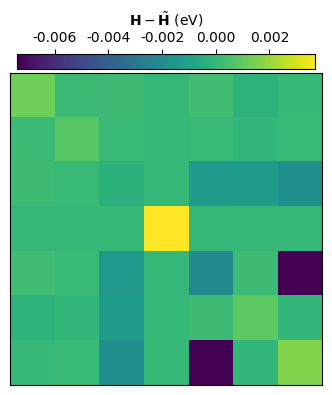

In [83]:
plt.figure()
plt.matshow((recon_H_test[0]-ml_data.target.tensor[testidx][0])*ha2ev)
plt.colorbar(location = 'top', orientation = 'horizontal', format = '%.3f', label = r'$\mathbf{H} - \tilde{\mathbf{H}}$ (eV)', shrink=0.8, pad=1e-2)
plt.xticks([])
plt.yticks([])
plt.savefig('water_1000_test0_diff.pdf', dpi=300, bbox_inches='tight')

In [2]:
# eigs_train = np.stack(pred_focks[:NTRAIN].flatten())
# eigs_actual_train = np.stack(fock[:NTRAIN].flatten())


# print(eigs_train.shape)

# for i in range(NTRAIN):
#     plt.plot(eigs_actual_train[i] -  eigs_train[i], 'o', alpha = 0.5)
# plt.legend()
# plt.plot(eigs_actual_train, eigs_actual_train, 'o', alpha = 0.5)
# plt.plot([-1,0.4], [-1,0.4], 'k--')
# plt.plot([-20,1], [-20,1], 'k--')
# plt.figure()


# eigs_test = np.stack(pred_focks[NTRAIN:].flatten())
# eigs_actual_test = np.stack(fock[NTRAIN:].flatten())
# for i in range(N-NTRAIN):
    # plt.plot(eigs_actual_test[i]-eigs_test[i], 'o', alpha = 0.5)
# plt.plot([-1,0.4], [-1,0.4], 'k--')
# plt.plot([-22,1], [-22,1], 'k--')
# plt.ylim(,-20)


In [154]:
L2_loss(eigs_actual_test, eigs_test)

In [156]:
eigs_actual_test

[array([-20.24312671,  -1.35313467,  -0.66698874,  -0.48750944,
         -0.40961951,   0.73845092,   0.8715896 ])]

In [158]:
print('test', np.linalg.norm(eigs_actual_test[0] - eigs_test[0]))
print('train', np.linalg.norm(eigs_actual_train[0] - eigs_train[0]))

test 0.07573563047937006
train 7.589684288351176e-07


# WATER TORCH

In [30]:
model = LinearTargetModel(
    dataset=ml_data, nlayers=1, nhidden=16, bias=True, device="cpu", activation = 'SiLU'
)

model = model.double()

In [31]:
model

LinearTargetModel(
  (model): ModuleDict(
    ((0, 8, 1, 0, 8, 1, 0, 0)): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=720, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    ((0, 8, 1, 0, 8, 2, 0, 0)): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=720, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    ((0, 8, 1, 0, 8, 2, 1, 1)): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=1152, out_features=16, bias=False)
        (1): Linear(in_features=16, out_features=1, bias=False)
      )
    )
    ((0, 8, 2, 0, 8, 2, 0, 0)): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=720, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    ((0, 8, 2, 0, 8, 2, 1, 1)): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=1152, out_features=16, bias=False)
        (1

# WATER -torch - periodic dataset

In [ ]:
import hickle
workdir = '../my_mlelec/examples/data/water_1000'
frames = read(f'{workdir}/water_1000.xyz',':1')
fock = hickle.load(f'{workdir}/sto-3g/fock.hickle')


In [ ]:
dataset =QMDataset(frames = frames, 
                kmesh = [1,1,1], 
                fix_p_orbital_order=True,
                dimension = 0,
                # fock_kspace = kfock, 
                # overlap_kspace = kover, 
                fock_realspace=fock,#[{tuple([0,0,0]):fock}],
                device = device, 
                orbs = orbitals['sto-3g'], 
                orbs_name = None
                )

In [ ]:
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = np.inf, device = device, all_pairs = False)

In [ ]:
LCUT = 4
hfeat = compute_features(dataset, hypers_atom=hypers_atom, hypers_pair=hypers_pair, lcut=LCUT)

In [ ]:
trainidx = np.arange(0, 800)
testidx = np.arange(800,1000)

In [ ]:
hfeat_train = mts.slice(hfeat, 'samples', Labels(['structure'], values = torch.from_numpy(trainidx).reshape(-1,1)))
hfeat_test = mts.slice(hfeat, 'samples', Labels(['structure'], values = torch.from_numpy(testidx).reshape(-1,1)))

In [ ]:
target_train = mts.slice(target_coupled_blocks, 'samples', Labels(['structure'], values = torch.from_numpy(trainidx).reshape(-1,1)))
target_test = mts.slice(target_coupled_blocks, 'samples', Labels(['structure'], values = torch.from_numpy(testidx).reshape(-1,1)))

In [ ]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_train, 
                                  target_blocks = target_train,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_train,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -1, 100),
                                                                         # alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

In [ ]:
pred_train = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_train)
pred_test = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_test)


In [ ]:
pred_all = mts.join([pred_train, pred_test], 'samples', remove_tensor_name = True)

In [ ]:
recon_train = blocks_to_matrix(pred_all, dataset)
# recon_test = blocks_to_matrix(pred_train, dataset)

In [ ]:
pred_focks = torch.stack([recon_train[i][0,0,0].detach() for i in range(len(dataset))])
from mlelec.metrics import L2_loss
print('train loss', L2_loss(pred_focks[:800], fock[:800]))
print('test loss', L2_loss(pred_focks[800:], fock[800:]))
# np.linalg.norm(np.array(pred_focks) -fock.numpy())**2

In [ ]:
eigs = [torch.linalg.eigvalsh(pred_focks[i]) for i in range(len(dataset))]
eigs_actual = [torch.linalg.eigvalsh(fock[i]) for i in range(len(dataset))]

In [ ]:
eigs_train = torch.cat(eigs[:800])
eigs_actual_train = torch.cat(eigs_actual[:800])
print(eigs_train.shape)
plt.plot(eigs_actual_train, eigs_train, 'o', alpha = 0.05)
plt.plot([-22,1], [-22,1], 'k--')

eigs_test = torch.cat(eigs[800:])
eigs_actual_test = torch.cat(eigs_actual[800:])
plt.plot(eigs_actual_test, eigs_test, 'o', alpha = 0.05)
plt.plot([-22,1], [-22,1], 'k--')

In [ ]:
print(L2_loss(eigs_train, eigs_actual_train))
print(L2_loss(eigs_test, eigs_actual_test))

# ETHANOL

In [ ]:
# workdir = '/Users/jigyasa/scratch/data_papers/hamiltonian/ethanol/dataset'
N = 1
workdir = '/home/nigam/scratch/MAC/data/hamiltonian/molecule/ethanol/dataset'
savedir = '/home/nigam/scratch/MAC/mlelec/jtests/ethanol'
frames = read(f'{workdir}/ethanol_4500.xyz',slice(0,N))
fock = np.load(f'{workdir}/ethanol_fock.npy')[:N].astype(np.float64)

# fock = np.load(f'{workdir}/ethanol_saph_orthogonal.npy')[:10].astype(np.float64)
fock_ = fock.copy()
overlap = np.load(f'{workdir}/ethanol_overlap.npy')[:N].astype(np.float64)
overlap_ = overlap.copy()
# fock = torch.from_numpy(fock)

for i in range(len(fock)):
    fock[i] = 0.5*(fock[i] + fock[i].T)
    overlap[i] = 0.5*(overlap[i] + overlap[i].T)

fock = torch.from_numpy(fock)
overlap = torch.from_numpy(overlap)

In [ ]:
# print(np.linalg.norm(dataset.overlap_realspace[0] - overlap_[0]))
# plt.matshow(dataset.fock_realspace[1] - fock_[1])

In [ ]:
dataset =QMDataset(frames = frames, 
                kmesh = [1,1,1], 
                fix_p_orbital_order=False,
                dimension = 0,
                overlap_realspace=overlap,
                fock_realspace=fock,#[{tuple([0,0,0]):fock}],
                device = device, 
                orbs = orbitals['def2svp'], 
                # orbs = orbitals['saph'], 
                orbs_name = None
                )

In [ ]:
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = 8, device = device, all_pairs = False)

In [ ]:
cutoff=8
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3
LCUT = 4

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
all_pairs = False


cutoff = 4
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis":  {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

# hfeat = compute_features(dataset, hypers_atom=hypers_atom, hypers_pair=hypers_pair, lcut=LCUT)

In [ ]:
frames[0].get_all_distances().max()

In [ ]:
from mlelec.data.dataset import MoleculeDataset, MLDataset
mol_data = MoleculeDataset(
    mol_name="ethanol",
    use_precomputed=False,
    frames = frames,  # Uses precomputed data by this name 
    frame_slice=slice(0, N), # Loads 100 frames 
    device="cpu",
    target_data = {"fock": fock},
    aux_data={"overlap": overlap, "orbitals": orbitals['def2svp']},
    aux=["overlap", "orbitals"],
    target=["fock"],
)

In [ ]:
L2_loss(ml_data.target.tensor , fock)

In [ ]:
ml_data = MLDataset(
    molecule_data=mol_data,
    device="cpu",
    model_strategy="coupled", # We will be building models for coupled blocks 
    shuffle=False,
    # shuffle_seed=None,
)  

ml_data._split_indices(1,0,0)

In [ ]:
from mlelec.features.acdc import compute_features_for_target
hfeat = compute_features_for_target(ml_data, hypers=hypers_atom, hypers_pair=hypers_pair, lcut=LCUT)

In [ ]:
for k in ["cell_shift_a", "cell_shift_b", "cell_shift_c","cell_shift_a_MIC","cell_shift_b_MIC", "cell_shift_c_MIC"]:
    hfeat = mts.remove_dimension(hfeat, "keys", k)

In [ ]:
NTRAIN = 1
trainidx = np.arange(0, NTRAIN)
testidx = np.arange(NTRAIN, N)#len(dataset))

In [ ]:
hfeat_train = mts.slice(hfeat, 'samples', Labels(['structure'], values = (trainidx).reshape(-1,1)))
hfeat_test = mts.slice(hfeat, 'samples', Labels(['structure'], values = (testidx).reshape(-1,1)))

In [ ]:
# hfeat.save(f'{savedir}/hfeat_500')
# target_coupled_blocks.save(f'{savedir}/coupledblocks_500')

In [ ]:
target_coupled_blocks = ml_data.target.blocks_coupled

In [ ]:
ml_data._set_features(hfeat_train)

In [ ]:
target_train = mts.slice(target_coupled_blocks, 'samples', Labels(['structure'], values = (trainidx).reshape(-1,1)))
target_test = mts.slice(target_coupled_blocks, 'samples', Labels(['structure'], values = (testidx).reshape(-1,1)))

In [ ]:
ml_data.test_idx

In [ ]:
# model_ridge = LinearModelPeriodic(twocfeat = hfeat_train, 
#                                   target_blocks = target_train,
#                                 #   frames = dataset.structures, 
#                                  frames = frames, 
#                                 #   orbitals = dataset.orbitals, 
#                                   orbitals = mol_data.aux_data["orbitals"], 
#                                   device = device)
model_ridge = LinearTargetModel(
    dataset=ml_data, nlayers=1, nhidden=16, bias=False, device="cuda"
)

model_ridge = model_ridge.double()
# loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
#                                                                          target_train,
#                                                                          set_bias = True,
#                                                                          kernel_ridge = False,
#                                                                          alphas = np.logspace(-8, -7, 100),
#                                                                          # alphas = np.logspace(-30, -6, 100),
#                                                                          # alpha = 1e-4
#                                                                         )
pred_train, ridges = model_ridge.fit_ridge_analytical(set_bias=True,alphas = np.logspace(-8, -6, 100),)
# print(loss_ridge_bias)


In [ ]:
pred_train = pred_train.to("cpu")

In [ ]:
from mlelec.metrics import L2_loss  
L2_loss(pred_train, target_train)

In [ ]:
from mlelec.utils.twocenter_utils import (
    map_targetkeys_to_featkeys,
    _to_uncoupled_basis,
    _to_matrix,
)
            
recon_H  = _to_matrix(
    _to_uncoupled_basis(pred_train, device="cpu" ),
   frames[0],
    ml_data.target.orbitals,
    device="cpu",
)

In [ ]:
recon_H

In [ ]:
ml_data.target.tensor.shape

In [ ]:
torch.sqrt(torch.sum((recon_H- ml_data.target.tensor[0])**2)/(72*72)) *27.211

In [ ]:
# plot_block_errors(target_train, pred_ridge_bias, plot_loss=True)

In [ ]:
pred_train = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_train)
pred_test = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_test)


In [ ]:
pred_all = pred_train #mts.join([pred_train, pred_test], 'samples', remove_tensor_name = True)

In [ ]:
recon_train = blocks_to_matrix(pred_all, dataset)
# recon_test = blocks_to_matrix(pred_train, dataset)

In [ ]:
pred_focks = torch.stack([recon_train[i][0,0,0].detach() for i in range(len(dataset))])
from mlelec.metrics import L2_loss

print('train loss', L2_loss(pred_focks[:NTRAIN], fock[:NTRAIN]))
print('test loss', L2_loss(pred_focks[NTRAIN:], fock[NTRAIN:]))
# np.linalg.norm(np.array(pred_focks) -fock.numpy())**2

In [ ]:
# pred_focks.shape
fock.shape

In [ ]:
for i in range(len(dataset)):
    print(i, torch.norm(dataset.fock_realspace[i] - dataset.fock_realspace[i].T))
    # print(i, np.linalg.norm(dataset.overlap_realspace[i] - dataset.overlap_realspace[i].T))

In [ ]:
import scipy
eigs = [scipy.linalg.eigvals(pred_focks[i], dataset.overlap_realspace[i]) for i in range(len(dataset))]
eigs_actual = [scipy.linalg.eigvals(fock[i], overlap[i]) for i in range(len(dataset))]

# eigs = [scipy.linalg.eigvals(pred_focks[i]) for i in range(len(dataset))]
# eigs_actual = [scipy.linalg.eigvals(fock[i]) for i in range(len(dataset))]

In [ ]:
eigs_train = np.stack(pred_focks[:NTRAIN].flatten())
eigs_actual_train = np.stack(fock[:NTRAIN].flatten())
print(eigs_train.shape)
plt.plot(eigs_actual_train, eigs_train, 'o', alpha = 0.5)
# plt.plot(eigs_actual_train, eigs_actual_train, 'o', alpha = 0.5)
# plt.plot([-1,0.4], [-1,0.4], 'k--')
plt.plot([-20,4], [-20,4], 'k--')
plt.figure()
eigs_test = np.stack(pred_focks[NTRAIN:].flatten())
eigs_actual_test = np.stack(fock[NTRAIN:].flatten())
plt.plot(eigs_actual_test, eigs_test, 'o', alpha = 0.5)
# plt.plot([-1,0.4], [-1,0.4], 'k--')
plt.plot([-20,4], [-20,4], 'k--')


In [ ]:
eigs = [scipy.linalg.eigvalsh(pred_focks[i]) for i in range(len(dataset))]
eigs_actual = [scipy.linalg.eigvalsh(fock[i]) for i in range(len(dataset))]

In [ ]:
eigs_train = np.stack(eigs[:NTRAIN])
eigs_actual_train = np.stack(eigs_actual[:NTRAIN])
print(eigs_train.shape)
plt.plot(eigs_actual_train, eigs_train, 'o', alpha = 0.5)
# plt.plot(eigs_actual_train, eigs_actual_train, 'o', alpha = 0.5)
# plt.plot([-22,5], [-22,5], 'k--')
plt.figure()
eigs_test = np.stack(eigs[NTRAIN:])
eigs_actual_test = np.stack(eigs_actual[NTRAIN:])
plt.plot(eigs_actual_test, eigs_test, 'o', alpha = 0.5)
# plt.plot([-22,5], [-22,5], 'k--')

In [ ]:
print(L2_loss(eigs_train, eigs_actual_train))
print(L2_loss(eigs_test, eigs_actual_test))